## Minimal StreamImages Client

In [1]:
# Minimal full workflow example
import json
from daq_data.client import DaqDataClient

# Load DAQ configuration
with open('daq_data/config/daq_config_grpc_simulate.json', 'r') as f:
    daq_config = json.load(f)

try:
    with DaqDataClient(daq_config) as client:
        # 1. Get valid hosts
        valid_hosts = client.get_valid_daq_hosts()
        if not valid_hosts:
            raise RuntimeError("No valid DAQ hosts found.")
        print(f"Connected to: {valid_hosts}")

        # 2. Initialize servers in simulation mode
        all_init_success = client.init_sim(valid_hosts)
        if not all_init_success:
            raise RuntimeError("Failed to initialize one or more servers.")
        print("All servers initialized for simulation.")

        # 3. Stream pulse-height and movie data from all modules
        image_stream = client.stream_images(
            hosts=valid_hosts,
            stream_movie_data=True,
            stream_pulse_height_data=True,
            update_interval_seconds=1.0,
            module_ids=()
        )

        # 4. Listen to the stream and process data
        print("Starting data stream. Press Ctrl+C to stop.")
        for image_data in image_stream:
            # In a real application, you would pass this data to a
            # visualization or analysis function.
            print(
                f"Image: Module {image_data['module_id']}, "
                f"Type: {image_data['type']}, "
                f"Timestamp: {image_data['header']['pandas_unix_timestamp']}"
            )

except KeyboardInterrupt:
    print("\nStream stopped by user.")
except Exception as e:
    print(f"An error occurred: {e}")

Connected to: {'localhost', '10.0.0.60'}


12:14:07 INFO     [tid=8757206784] [init_hp_io()] Initializing the hp_io thread with         ]8;id=67288;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=232414;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#365\365]8;;\
                  {'data_dir': 'simulated_data_dir', 'update_interval_seconds': 0.5,                               
                  'force': True, 'simulate_daq': True, 'module_ids': []}                                           

12:14:10 INFO     [tid=8757206784] [init_hp_io()] host='localhost':                          ]8;id=209112;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=510288;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#369\369]8;;\
                  init_hp_io_response.success=True                                                                 

         INFO     [tid=8757206784] [init_hp_io()] Initializing the hp_io thread with         ]8;id=478035;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=320258;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#365\365]8;;\
                  {'data_dir': 'simulated_data_dir', 'update_interval_seconds': 0.5,                               
                  'force': True, 'simulate_daq': True, 'module_ids': []}                                           

12:14:12 INFO     [tid=8757206784] [init_hp_io()] host='10.0.0.60':                          ]8;id=665811;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=548639;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#369\369]8;;\
                  init_hp_io_response.success=True                                                                 

All servers initialized for simulation.


         INFO     [tid=8757206784] [stream_images()]                                         ]8;id=5613;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=415752;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#279\279]8;;\
                  stream_images_request={'stream_movie_data': True,                                                
                  'stream_pulse_height_data': True, 'update_interval_seconds': 1.0,                                
                  'module_ids': []}                                                                                

         INFO     [tid=8757206784] [stream_images()] Created StreamImages RPC to             ]8;id=164654;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=5301;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#289\289]8;;\
                  host='localhost'                                                                                 

         INFO     [tid=8757206784] [stream_images()] Created StreamImages RPC to             ]8;id=520056;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=559535;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#289\289]8;;\
                  host='10.0.0.60'                                                                                 

Starting data stream. Press Ctrl+C to stop.
Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:00.671721061
Image: Module 24, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:34:57.942348980
Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.701007488
Image: Module 24, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.696007488


## Visualization Client Example

In [2]:
from pathlib import Path
import json
from rich import print
import logging

from daq_data.client import DaqDataClient
from daq_data.plot import PanoImagePreviewer, PulseHeightDistribution

%load_ext autoreload
%autoreload 2

In [3]:
# Configure paths
cfg_dir = Path('daq_data/config')
daq_config_file = 'daq_config_grpc_simulate.json'
hp_io_config_simulate_file = 'hp_io_config_simulate.json'

# Load configuration files
with open(cfg_dir / hp_io_config_simulate_file, 'r') as f:
    hp_io_cfg = json.load(f)

with open(cfg_dir / daq_config_file, 'r') as f:
    daq_config = json.load(f)

In [9]:
# initialize the server
with DaqDataClient(daq_config, log_level=logging.INFO) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    if len(valid_daq_hosts) == 0:
        print(f"no valid daq hosts")
    service_summary = ddc.reflect_services([])
    print(service_summary)
    all_init_success = ddc.init_sim([])
    print(f"\t{all_init_success=}")


19:33:57 INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=187824;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=219698;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: daq_data.proto                                                            

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=572496;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=809832;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/struct.proto                                              

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=429253;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=294488;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file:                                                                           
                  google/protobuf/timestamp.proto                                                                  

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=968042;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=958614;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/empty.proto                                               

Reflecting services on localhost:50051:
        found services: ['daqdata.DaqData', 'grpc.reflection.v1alpha.ServerReflection']
        found DaqData service with name: daqdata.DaqData
        found: rpc StreamImages(StreamImagesRequest) returns (stream StreamImagesResponse)
        found: rpc InitHpIo(InitHpIoRequest) returns (InitHpIoResponse)
        found: rpc Ping(Empty) returns (Empty)

all_init_success=True

#### Streaming from One DAQ node

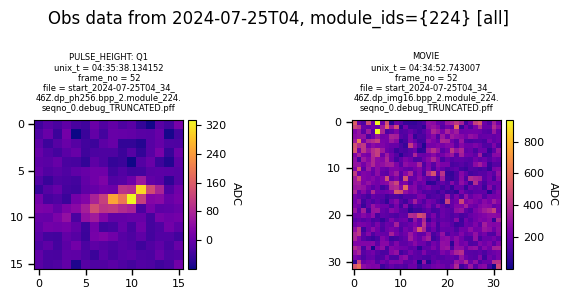

In [10]:
# Show PanoImagePreviewer: One DAQ node

with DaqDataClient(daq_config) as ddc:
    
    # Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        # module_id_whitelist=[],
        jupyter_notebook=True
    )

    # Get first valid daq node
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    host = list(valid_daq_hosts)[0] 
    
    # Call the StreamImages RPC on one valid DAQ node
    pano_image_stream = ddc.stream_images(
        host,
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=2.0,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update visualization
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

#### Streaming from Multiple DAQ Nodes

In [5]:
# Show PanoImagePreviewer: Multiple DAQ nodes

# 1. Connect to all DAQ nodes
with DaqDataClient(daq_config) as ddc:
    
    # 2. Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        module_id_whitelist=[],
        jupyter_notebook=True
    )
    
    # 3. Call the StreamImages RPC on all valid DAQ nodes
    pano_image_stream = ddc.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # 4. Update visualization for each pano_image
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

19:33:13 ERROR    [tid=8757206784] [__exit__()] etype=<class                                          ]8;id=944697;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=882251;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#136\136]8;;\
                  'grpc._channel._MultiThreadedRendezvous'>, value=<_MultiThreadedRendezvous of RPC                
                  that terminated with:                                                                            
                          status = StatusCode.FAILED_PRECONDITION                                                  
                          details = "Uninitialized hp_io task. Run InitHpIo with a valid hp_io                     
                  configuration to initialize it."                                                                 
                          debug_error_string = "UNKNOWN:Error received from peer                                   
                  {grpc_message:"Uninitialized hp_io task. Run InitHpIo with a valid hp_io                         
                  configuration to initialize it.", grpc_status:9}"                                                
                  >, traceback=<traceback object at 0x1689130c0>                                                   

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.FAILED_PRECONDITION
	details = "Uninitialized hp_io task. Run InitHpIo with a valid hp_io configuration to initialize it."
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"Uninitialized hp_io task. Run InitHpIo with a valid hp_io configuration to initialize it.", grpc_status:9}"
>